<a href="https://colab.research.google.com/github/ThilankaPerera/week05/blob/main/Colab_task_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow


Weather Prediction Using RNN



In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the dataset
weather_data = pd.read_csv('/content/drive/MyDrive/dataset/seattle-weather.csv')

# Display the first few rows of the dataset
weather_data.head()


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [ ]:
# Check for missing values in each column
weather_data.isnull().sum()


,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [ ]:
# Check for duplicate rows in the dataset
weather_data.duplicated().sum()


0

In [ ]:
# Convert 'date' column to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

In [ ]:
# One-Hot Encoding for 'weather' column
encoder = OneHotEncoder(sparse_output=False)
weather_encoded = encoder.fit_transform(weather_data[['weather']])

# Convert to DataFrame and merge with original dataset
encoded_columns = encoder.get_feature_names_out(['weather'])
weather_encoded_df = pd.DataFrame(weather_encoded, columns=encoded_columns)

# Drop original 'weather' column & merge encoded features
weather_df = pd.concat([weather_data.drop(columns=['weather']), weather_encoded_df], axis=1)

# Display updated dataset
print(weather_df.head())

        date  precipitation  temp_max  temp_min  wind  weather_drizzle  \
0 2012-01-01            0.0      12.8       5.0   4.7              1.0   
1 2012-01-02           10.9      10.6       2.8   4.5              0.0   
2 2012-01-03            0.8      11.7       7.2   2.3              0.0   
3 2012-01-04           20.3      12.2       5.6   4.7              0.0   
4 2012-01-05            1.3       8.9       2.8   6.1              0.0   

   weather_fog  weather_rain  weather_snow  weather_sun  
0          0.0           0.0           0.0          0.0  
1          0.0           1.0           0.0          0.0  
2          0.0           1.0           0.0          0.0  
3          0.0           1.0           0.0          0.0  
4          0.0           1.0           0.0          0.0  


In [ ]:
# Normalize numerical features using MinMaxScaler
features = ['precipitation', 'temp_max', 'temp_min', 'wind']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(weather_df[features])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Merge scaled data with encoded weather features
final_df = pd.concat([scaled_df, weather_encoded_df], axis=1)

# Display final processed data
print(final_df.head())

   precipitation  temp_max  temp_min      wind  weather_drizzle  weather_fog  \
0       0.000000  0.387097  0.476378  0.472527              1.0          0.0   
1       0.194991  0.327957  0.389764  0.450549              0.0          0.0   
2       0.014311  0.357527  0.562992  0.208791              0.0          0.0   
3       0.363148  0.370968  0.500000  0.472527              0.0          0.0   
4       0.023256  0.282258  0.389764  0.626374              0.0          0.0   

   weather_rain  weather_snow  weather_sun  
0           0.0           0.0          0.0  
1           1.0           0.0          0.0  
2           1.0           0.0          0.0  
3           1.0           0.0          0.0  
4           1.0           0.0          0.0  


In [ ]:
# Function to create sequences for time series forecasting
def create_sequences(data, seq_length=7, target_col_index=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Last `seq_length` records as input
        y.append(data[i+seq_length, target_col_index])  # Predicting 'temp_max' (column index 1)
    return np.array(X), np.array(y)

# Define sequence length (how many past days to consider)
sequence_length = 7

# Convert DataFrame to NumPy array
data_array = final_df.values

# Create sequences
X, y = create_sequences(data_array, sequence_length, target_col_index=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shape of training and testing sets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (1163, 7, 9)
Testing data shape: (291, 7, 9)


In [ ]:
# Define LSTM model for weather prediction
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),  # Add dropout to prevent overfitting
    LSTM(50, activation='tanh'),
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(25, activation='relu'),
    Dense(1)  # Output layer to predict temp_max
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 50)               │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,501 (130.86 KB)

 Trainable params: 33,501 (130.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model (a type of RNN)
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0726 - val_loss: 0.0085
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0134 - val_loss: 0.0090
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - val_loss: 0.0087
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117 - val_loss: 0.0078
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0112 - val_loss: 0.0076
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0104 - val_loss: 0.0072
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - 

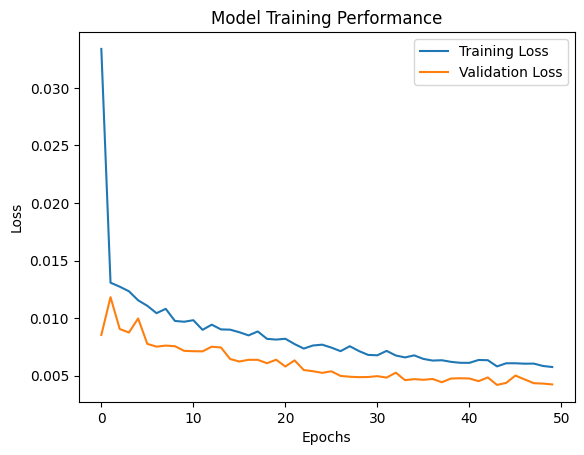

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Performance')
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


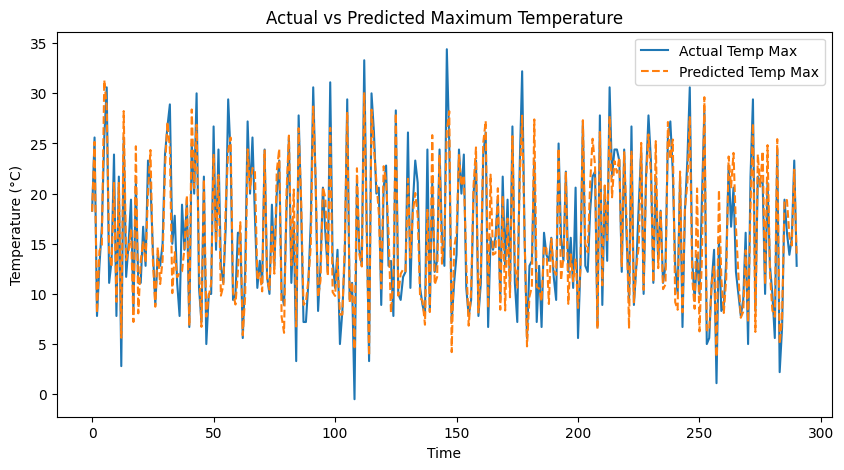

In [ ]:
# Predict temperature using test data
predicted_values = model.predict(X_test)

# Reverse scaling for comparison
predicted_temp_max = scaler.inverse_transform(np.column_stack((np.zeros((len(predicted_values), 1)), predicted_values, np.zeros((len(predicted_values), 2)))))[:, 1]
actual_temp_max = scaler.inverse_transform(np.column_stack((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1), np.zeros((len(y_test), 2)))))[:, 1]

# Plot actual vs predicted temperature
plt.figure(figsize=(10,5))
plt.plot(actual_temp_max, label="Actual Temp Max")
plt.plot(predicted_temp_max, label="Predicted Temp Max", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Maximum Temperature")
plt.legend()
plt.show()

Time Series Forecasting Using RNN(LSTM)

In [ ]:
# Import necessary Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt


In [ ]:
# Load the monthly milk production dataset
milk_df = pd.read_csv('/content/drive/MyDrive/dataset/monthly_milk_production.csv', index_col='Date', parse_dates=True)
milk_df.index.freq = 'MS'

# Display first few rows of the dataset
print(milk_df.head())


            Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727


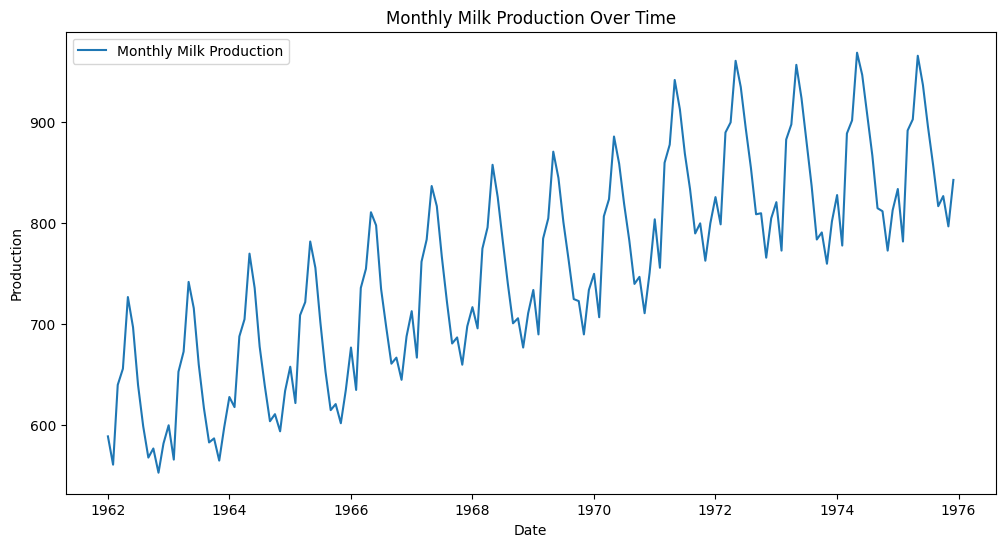

In [ ]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(milk_df.index, milk_df['Production'], label='Monthly Milk Production')
plt.title('Monthly Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
# Split the data into training and testing sets
train_data = milk_df.iloc[:156]  # First 156 months for training
test_data = milk_df.iloc[156:]   # Remaining 12 months for testing

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)  # Fit the scaler on the training data
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

# Define sequence length and features
sequence_length = 12  # Use 12 months to predict the next month
num_features = 1      # Only one feature (Production)

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=sequence_length, batch_size=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()

# Add SimpleRNN layer with 100 units (neurons)
model.add(SimpleRNN(100, activation='relu', input_shape=(sequence_length, num_features)))

# Output layer with one neuron
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 100)                 │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model for 50 epochs
history = model.fit(train_generator, epochs=50, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0453 - mae: 0.1547
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - mae: 0.0743
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - mae: 0.0568
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - mae: 0.0439
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - mae: 0.0481
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0293
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - mae: 0.0387
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - mae: 0.0424
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0315
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - mae: 0.0364
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mae: 0.0297
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1044e-04 - mae: 0.0234
Epoch 13/50
144/144 ━━━━━━━━━━━━

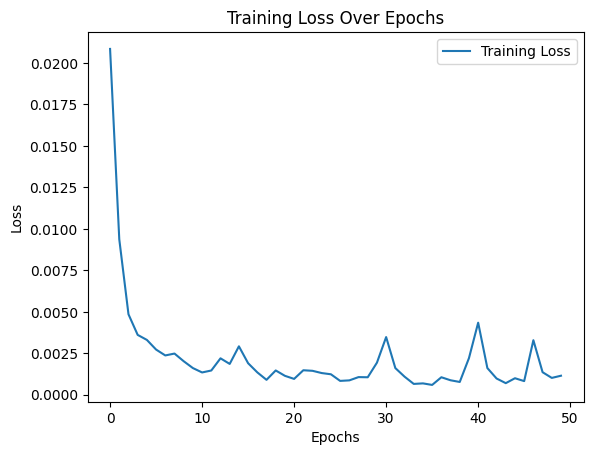

In [ ]:
# Extract loss history
loss_per_epoch = model.history.history['loss']

# Plot training loss per epoch
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


In [ ]:
# Prepare last 12 months of training data for first prediction
last_train_batch = scaled_train[-sequence_length:].reshape((1, sequence_length, num_features))

# Make single prediction
model.predict(last_train_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


array([[0.64752036]], dtype=float32)

In [ ]:
# Generate predictions for the test set
for i in range(len(test_data)):
    # Predict the next value
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)

    # Update the current batch (remove the first value and add the prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform the predictions to the original scale
true_predictions = scaler.inverse_transform(test_predictions)

# Add predictions to the test dataset
test_data['Predictions'] = true_predictions

# Display the first few rows of the test set with predictions
print("Test Data with Predictions:")
print(test_data.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Test Data with Predictions:
            Production  Predictions
Date                               
1975-01-01         834   822.368471
1975-02-01         782   779.742298
1975-03-01         892   854.214911
1975-04-01         903   850.323599
1975-05-01         966   909.459803


<ipython-input-49-e92a7320100e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predictions'] = true_predictions


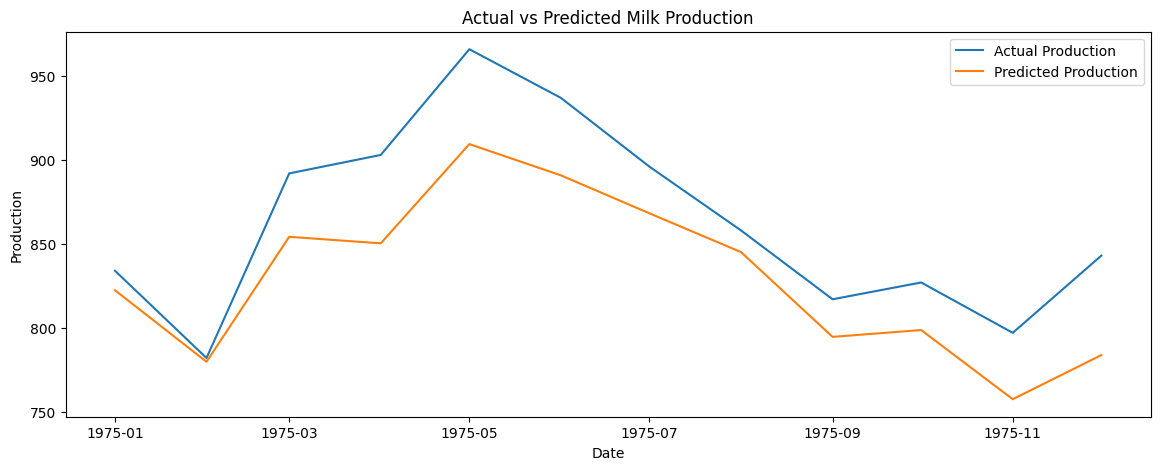

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(test_data.index, test_data['Production'], label='Actual Production')
plt.plot(test_data.index, test_data['Predictions'], label='Predicted Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data['Production'], test_data['Predictions']))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}%")

# Calculate MAPE and accuracy
mape = mean_absolute_percentage_error(test_data['Production'], test_data['Predictions'])
accuracy = 100 - (mape * 100)
print(f"Model Accuracy: {accuracy:.2f}%")

Root Mean Squared Error (RMSE): 37.63%
Model Accuracy: 96.22%


Generate music with RNN

In [ ]:
# Install required dependencies for FluidSynth, a library for generating audio from MIDI files
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
# Import necessary libraries
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional


In [ ]:
# Set random seed for reproducibility of results
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


In [ ]:
# Define the path to the dataset and check if it's already downloaded
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

# Get the list of MIDI file paths from the dataset
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 1282


In [ ]:
# Select a sample file from the dataset
sample_file = filenames[1]
print(sample_file)

# Load the selected MIDI file using PrettyMIDI
pm = pretty_midi.PrettyMIDI(sample_file)


data/maestro-v2.0.0/2009/MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_03_WAV.midi


In [ ]:
# Function to display audio for playback using FluidSynth
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds * _SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# Play the audio of the sample MIDI file
display_audio(pm)


In [ ]:
# Function to convert MIDI file to note-level data
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# Extract notes from the sample MIDI file
raw_notes = midi_to_notes(sample_file)


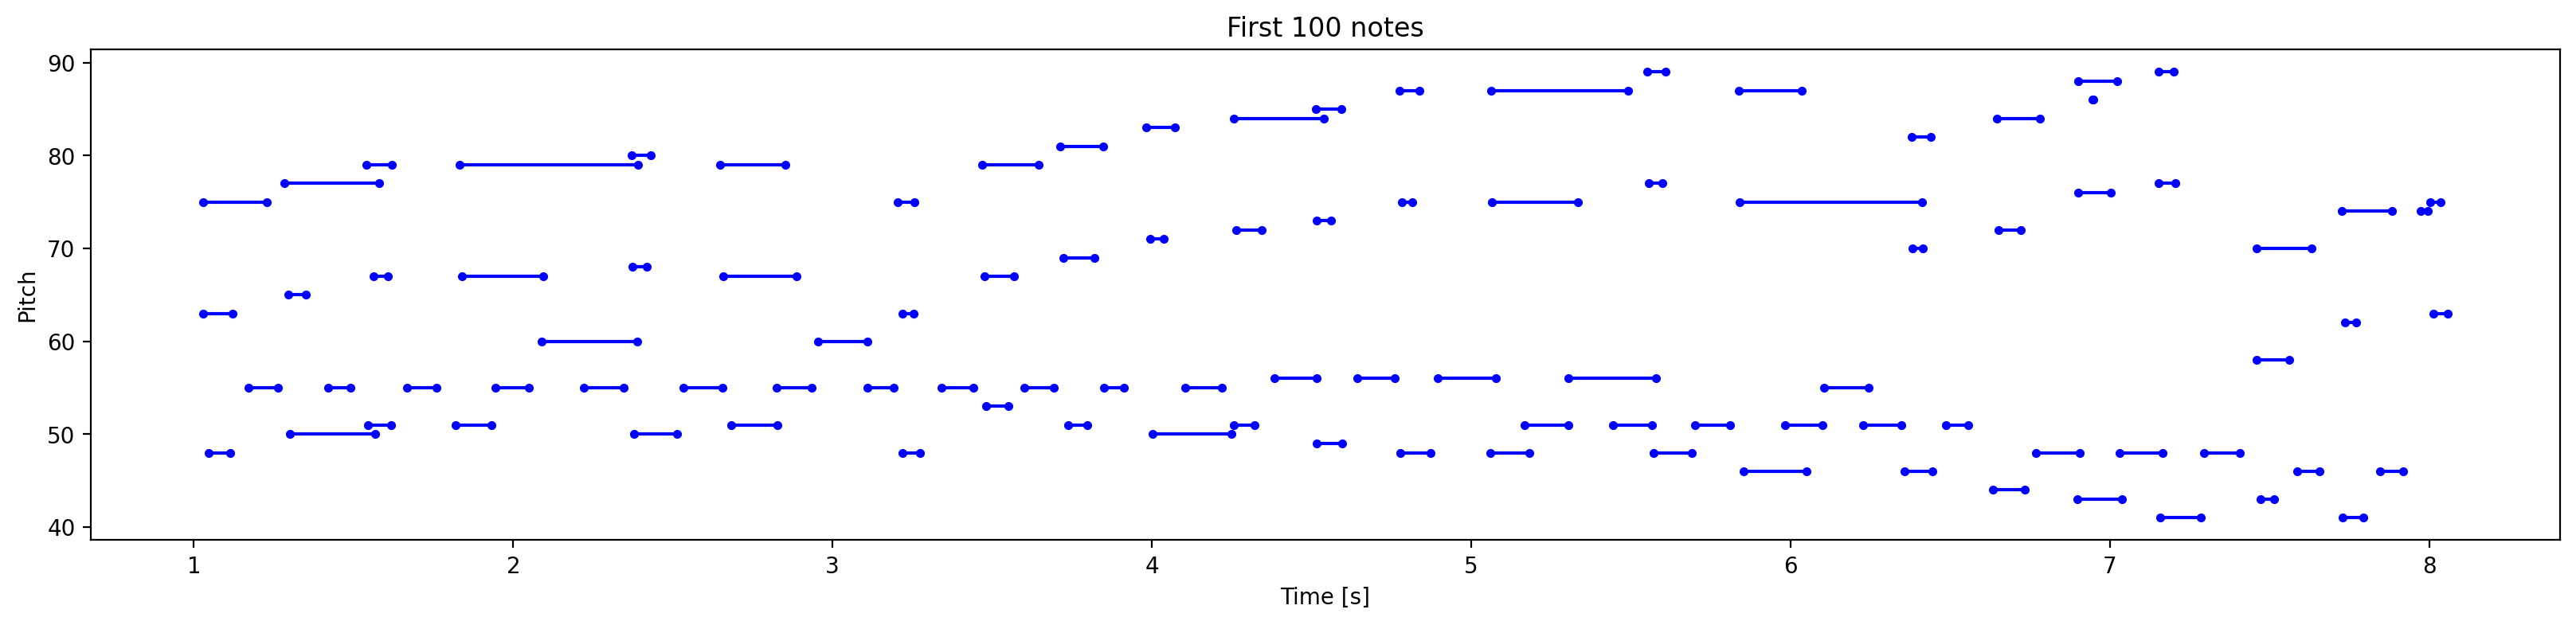

In [ ]:
# Function to plot a piano roll visualization of the MIDI notes
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

# Plot the first 100 notes of the sample
plot_piano_roll(raw_notes, count=100)


In [ ]:
# Function to convert the notes back into a MIDI file
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

# Convert the notes from the raw notes dataframe to a MIDI file
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name="Acoustic Grand Piano")

# Play the generated MIDI file
display_audio(example_pm)


In [ ]:
# Load multiple MIDI files and process them into a training dataset
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

# Concatenate all notes into a single dataframe
all_notes = pd.concat(all_notes)

# Get the number of notes in the dataset
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

# Define the order of keys to be used in the training dataset
key_order = ['pitch', 'step', 'duration']

# Stack the note data into a numpy array
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# Create a TensorFlow dataset from the note data
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)


Number of notes parsed: 22780


In [ ]:
# Function to create sequences from the dataset for training
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size=128,
) -> tf.data.Dataset:
    seq_length = seq_length + 1  # Include the label in the sequence length

    # Create windows of data with a stride of 1
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # Flatten the windowed data
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Scale the pitch and return the input-output pairs
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

# Define sequence length and vocab size
seq_length = 25
vocab_size = 128

# Create the training sequences
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)


In [ ]:
# Set the batch size and buffer size for the training dataset
batch_size = 64
buffer_size = n_notes - seq_length  # Number of items in the dataset

# Shuffle, batch, and prepare the dataset for training
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))


In [ ]:
#Define and Train the Model
# Define custom loss function that combines MSE and a positive pressure for note prediction
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

# Input shape based on the sequence length and number of features (pitch, step, duration)
input_shape = (seq_length, 3)

# Define the model architecture
inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

# Define the outputs for pitch, step, and duration
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with appropriate loss functions and optimizer
model.compile(
    loss={'pitch': 'sparse_categorical_crossentropy',
          'step': mse_with_positive_pressure,
          'duration': mse_with_positive_pressure},
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
)

# Print the model summary
model.summary()

# Train the model using the training dataset
model.fit(train_ds, epochs=20)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 25, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 128)            │         67,584 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm_4[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - duration_loss: 0.2071 - loss: 11.3168 - pitch_loss: 10.9472 - step_loss: 0.1624
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - duration_loss: 0.1502 - loss: 11.8529 - pitch_loss: 11.5687 - step_loss: 0.1341
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - duration_loss: 0.1465 - loss: 11.8848 - pitch_loss: 11.6039 - step_loss: 0.1345
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - duration_loss: 0.1445 - loss: 11.8472 - pitch_loss: 11.5692 - step_loss: 0.1335
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - duration_loss: 0.1442 - loss: 11.7363 - pitch_loss: 11.4587 - step_loss: 0.1334
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - duration_loss: 0.1414 - loss: 11.7161 - pitch_loss: 11.4424 - step_loss: 0.1322
Epoch 7/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - duration_loss: 0.1420 - loss: 11.7450 - pitch_loss: 11.4707 - step_loss: 0.1323
Epoch 8/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms

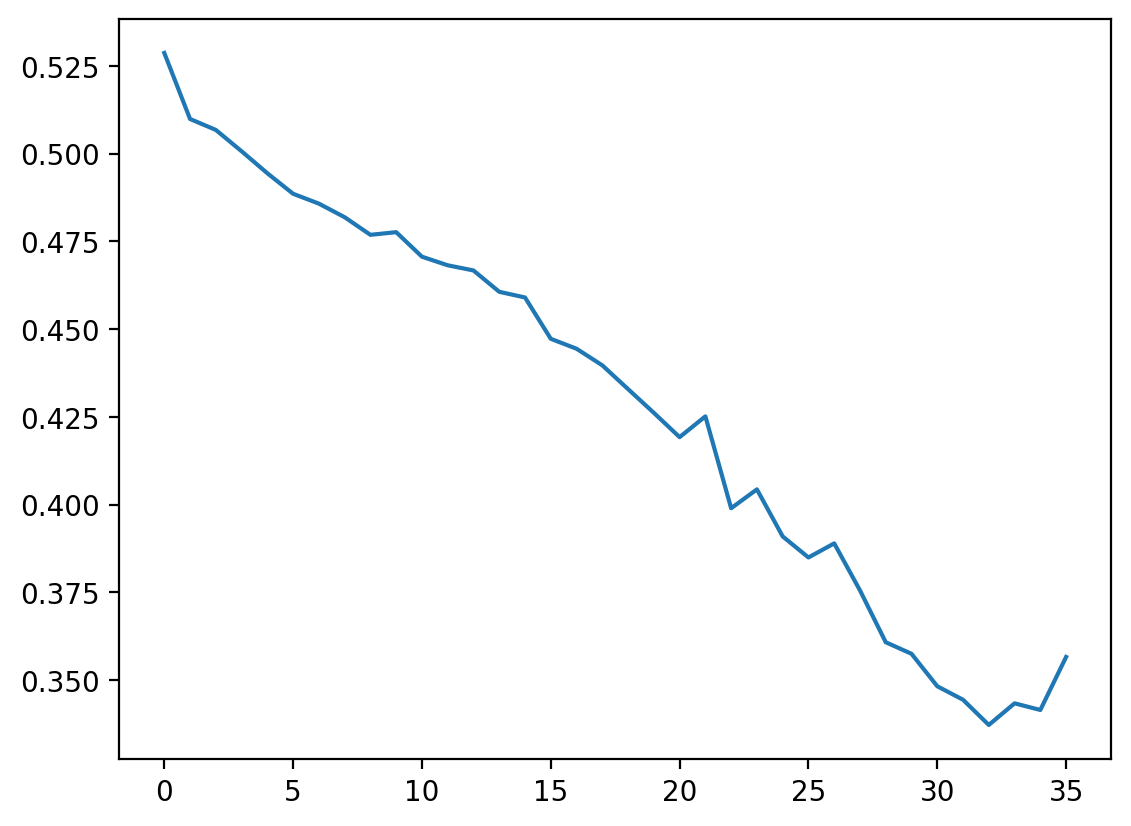

In [ ]:
# Plot the training loss over epochs
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
#Generating the Next Musical Note
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)


In [ ]:
# Generating a Sequence of Musical Notes Using a Trained Model
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [ ]:
#Displaying the First 10 Rows of Generated Musical Notes
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.085965,0.205868,0.085965,0.291833
1,120,0.000000,0.050025,0.085965,0.135990
2,118,0.000000,0.031310,0.085965,0.117275
3,56,0.000000,0.019663,0.085965,0.105627
4,89,0.000000,0.046597,0.085965,0.132562
5,66,0.000000,0.043032,0.085965,0.128996
6,15,0.000000,0.055529,0.085965,0.141493
7,86,0.000000,0.000000,0.085965,0.085965
8,1,0.000000,0.050197,0.085965,0.136161
9,80,0.058127,0.211533,0.144092,0.355625


In [ ]:
#Saving and Displaying Generated Music as MIDI
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)


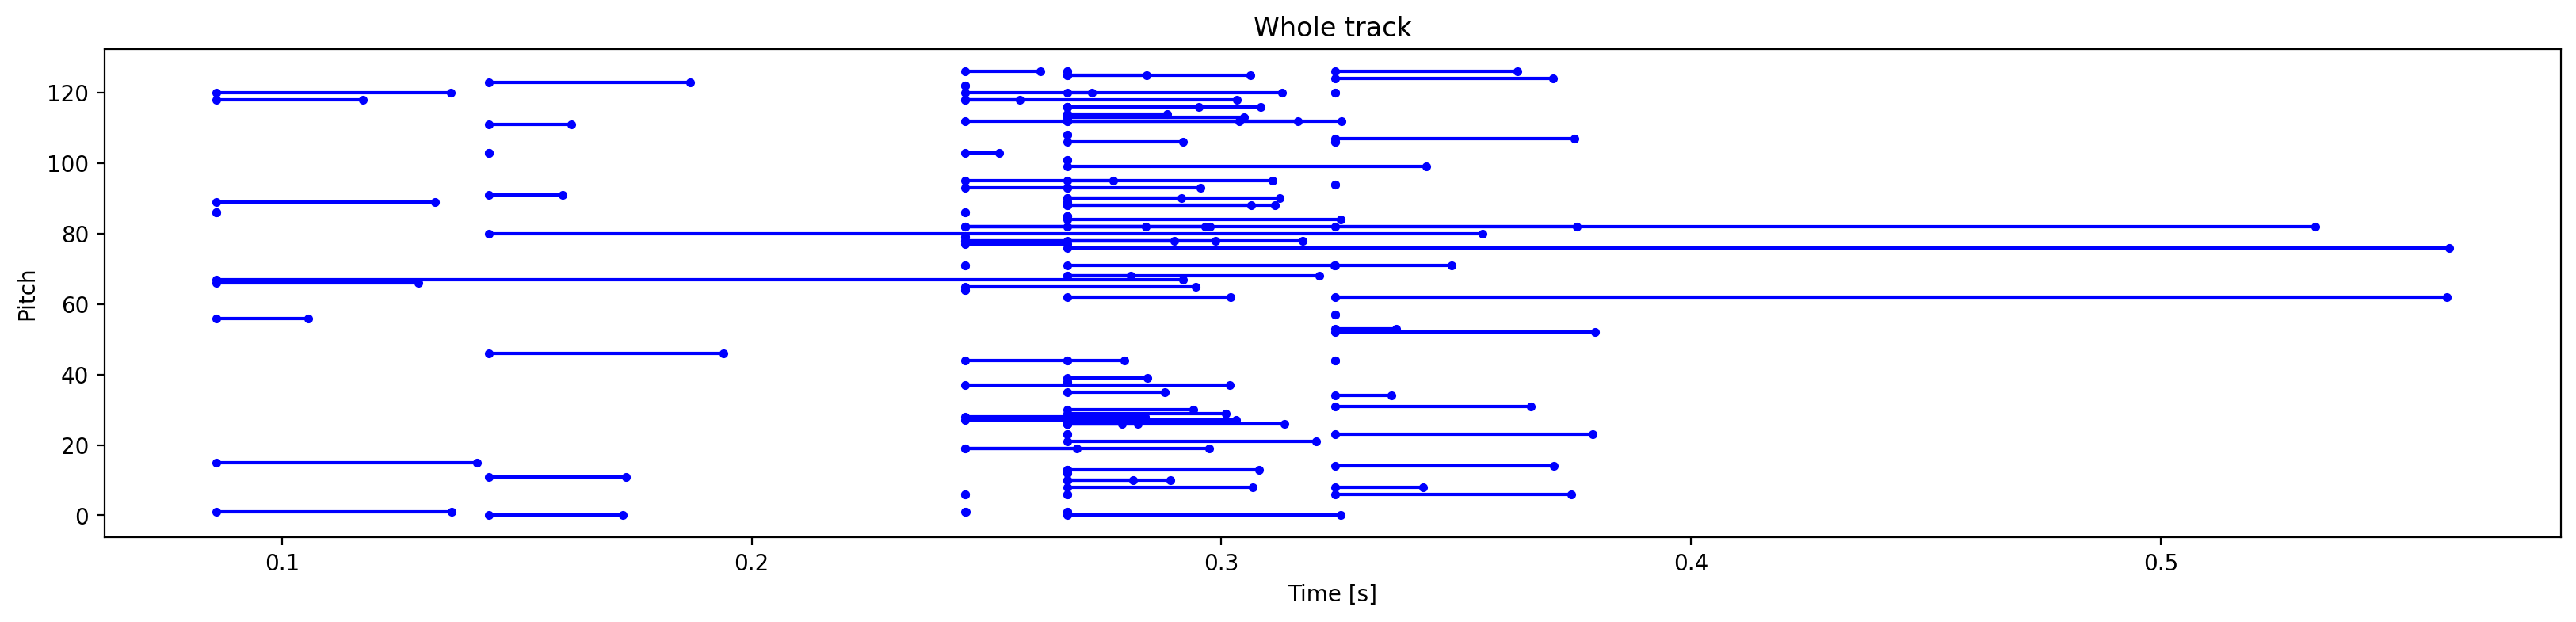

In [ ]:
#lotting the Piano Roll of Generated Music
plot_piano_roll(generated_notes)

Sentiment Analysis Using RNN

In [ ]:
# Install TensorFlow (if not already installed in Colab)
!pip install tensorflow numpy pandas matplotlib scikit-learn

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [ ]:

# Load dataset into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/dataset/IMDB Dataset.csv")

# Display first few rows
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import re
import string

# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning function
df['review'] = df['review'].apply(clean_text)

# Encode sentiment labels (if they are categorical)
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])  # Converts 'positive'/'negative' to 1/0

# Show processed data
df.head()


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [ ]:
# Set parameters
vocab_size = 10000  # Max number of words to keep in vocabulary
max_length = 100  # Max length of a review (padding/truncation)

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # Handle unknown words
tokenizer.fit_on_texts(df['review'])
word_index = tokenizer.word_index  # Dictionary of words and their indices

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review'])

# Padding sequences to ensure uniform input size
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Splitting data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=42)

# Display sample tokenized output
print("Sample original text:", df['review'][0])
print("Tokenized:", sequences[0])
print("Padded:", padded_sequences[0])


Sample original text: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with mebr br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordbr br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awaybr br i would say the main appeal of the show is due to the fact that it goes where other sh

In [ ]:
# Build the RNN Model (LSTM)
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_length,)),  # Specify input_shape
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)             │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,913 (5.12 MB)

 Trainable params: 1,342,913 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 112ms/step - accuracy: 0.6243 - loss: 0.6453 - val_accuracy: 0.6427 - val_loss: 0.6438
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 116ms/step - accuracy: 0.7512 - loss: 0.5182 - val_accuracy: 0.8216 - val_loss: 0.4017
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 225s 134ms/step - accuracy: 0.8606 - loss: 0.3396 - val_accuracy: 0.8438 - val_loss: 0.3552
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 114ms/step - accuracy: 0.8993 - loss: 0.2563 - val_accuracy: 0.8401 - val_loss: 0.3755
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 115ms/step - accuracy: 0.9277 - loss: 0.1943 - val_accuracy: 0.8325 - val_loss: 0.4478
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8293 - loss: 0.4471
Test Loss: 0.447785884141922
Test Accuracy: 0.8324999809265137


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probability to binary output

# Classification Report
print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8293 - loss: 0.4471
Test Accuracy: 0.8325
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      4961
           1       0.86      0.79      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



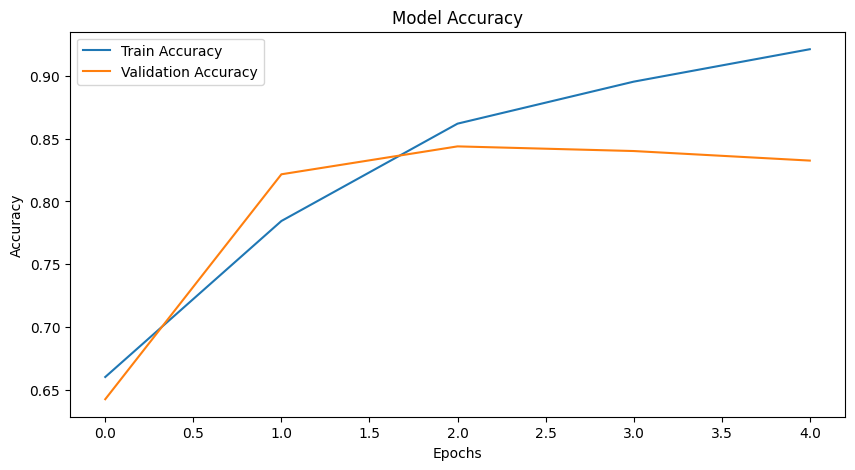

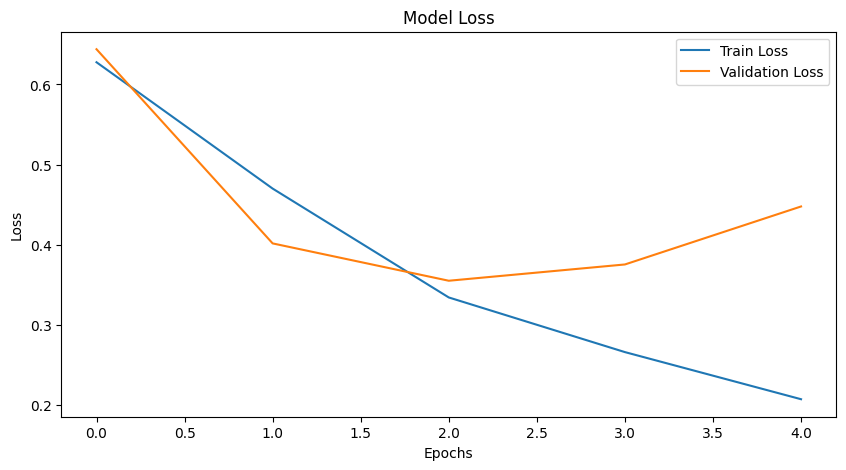

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


In [ ]:
# Function to predict sentiment of new text
def predict_sentiment(text):
    cleaned_text = clean_text(text)  # Clean text
    seq = tokenizer.texts_to_sequences([cleaned_text])  # Tokenize
    padded = pad_sequences(seq, maxlen=max_length, padding='post')  # Pad sequence
    prediction = model.predict(padded)[0][0]  # Get probability
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Review: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    return sentiment

# Example predictions
predict_sentiment("I love this product! It's amazing!")  # Expected: Positive
predict_sentiment("Worst experience ever. Totally disappointed.")  # Expected: Negative


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Review: I love this product! It's amazing!
Predicted Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: Worst experience ever. Totally disappointed.
Predicted Sentiment: Negative


'Negative'

Meta Stock Prediction using RNN

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Importing necessary modules
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [ ]:
# Loading the Dataset
metadata = pd.read_csv('/content/drive/MyDrive/dataset/META.csv')

# Displaying the first five rows of the dataset to understand its structure
metadata.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-01,163.029999,165.880005,161.259995,162.440002,162.440002,26407700
1,2018-10-02,161.580002,162.279999,158.669998,159.330002,159.330002,36031000
2,2018-10-03,160.000000,163.660004,159.529999,162.429993,162.429993,23109500
3,2018-10-04,161.460007,161.460007,157.350006,158.850006,158.850006,25739600
4,2018-10-05,159.210007,160.899994,156.199997,157.330002,157.330002,25744000


In [ ]:
# Split Data into Training and Validation Sets
# Get the total length of the dataset
length_data = len(metadata)

# Define the split ratio (70% training, 30% validation)
split_ratio = 0.7
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train

# Print dataset sizes
print('Total length of data:', length_data)
print('Training set length:', length_train)
print('Validation set length:', length_validation)


Total length of data: 1257
Training set length: 880
Validation set length: 377


In [ ]:
# Select training data (first 'length_train' rows) with only 'Date' and 'Open' columns
train_data = metadata[:length_train].iloc[:, :2]

# Convert the 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Display the first few rows of the training data
train_data.head()


,Date,Open
0,2018-10-01,163.029999
1,2018-10-02,161.580002
2,2018-10-03,160.000000
3,2018-10-04,161.460007
4,2018-10-05,159.210007


In [ ]:
# Select validation data (remaining rows) with only 'Date' and 'Open' columns
validation_data = metadata[length_train:].iloc[:, :2]

# Convert the 'Date' column to datetime format
validation_data['Date'] = pd.to_datetime(validation_data['Date'])

# Display the first few rows of the validation data
validation_data.head()



,Date,Open
880,2022-03-30,228.910004
881,2022-03-31,228.449997
882,2022-04-01,224.550003
883,2022-04-04,225.979996
884,2022-04-05,234.080002


In [ ]:
# Extract 'Open' price values as a NumPy array
dataset_train = train_data['Open'].values

# Display shape of the dataset
dataset_train.shape


(880,)

In [ ]:
# Reshape the dataset to 2D array (-1,1) for scaling
dataset_train = np.reshape(dataset_train, (-1, 1))

# Display new shape
dataset_train.shape


(880, 1)

In [ ]:
# Normalize the dataset using MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train_scaled = scaler.fit_transform(dataset_train)


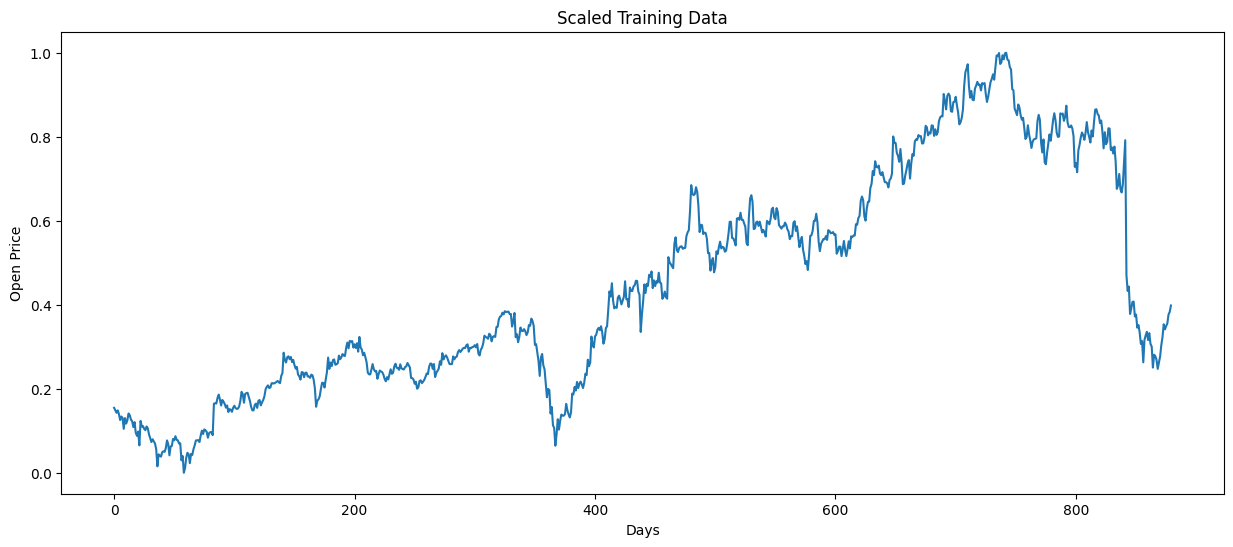

In [ ]:
#  Visualize Scaled Training Data
plt.figure(figsize=(15,6))
plt.plot(dataset_train_scaled)
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.title('Scaled Training Data')
plt.show()


In [ ]:
# Create Input Sequences for Training
# Define input (X) and output (y) lists
X_train = []
y_train = []

# Define time step (sequence length)
time_step = 50

# Create sequences of 50 time steps
for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i, 0])  # Previous 50 days as input
    y_train.append(dataset_train_scaled[i, 0])  # Next day's open price as output

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Display the shape of the training data
X_train.shape


(830, 50)

In [ ]:
# Initialize the Sequential model
reg = Sequential()

# Add first RNN layer with 50 units, tanh activation, and return sequences
reg.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
reg.add(Dropout(0.2))  # Add dropout to prevent overfitting

# Add second RNN layer
reg.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
reg.add(Dropout(0.2))

# Add third RNN layer
reg.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
reg.add(Dropout(0.2))

# Add fourth RNN layer (without return_sequences since it's the last RNN layer)
reg.add(SimpleRNN(units=50))
reg.add(Dropout(0.2))

# Output layer with 1 neuron for regression task
reg.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model using Adam optimizer and Mean Squared Error loss
reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
# Train the model with 100 epochs and batch size 32
history = reg.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.0020 - loss: 0.5183
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.0017 - loss: 0.3026
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0043 - loss: 0.2923
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0045 - loss: 0.2044
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.0016 - loss: 0.2108
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 6.6532e-04 - loss: 0.1601
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0017 - loss: 0.1260
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 8.3173e-04 - loss: 0.1147
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0025 - loss: 0.0972
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.0024 - loss: 0.0879
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.3554e-04 - loss: 0.0813
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


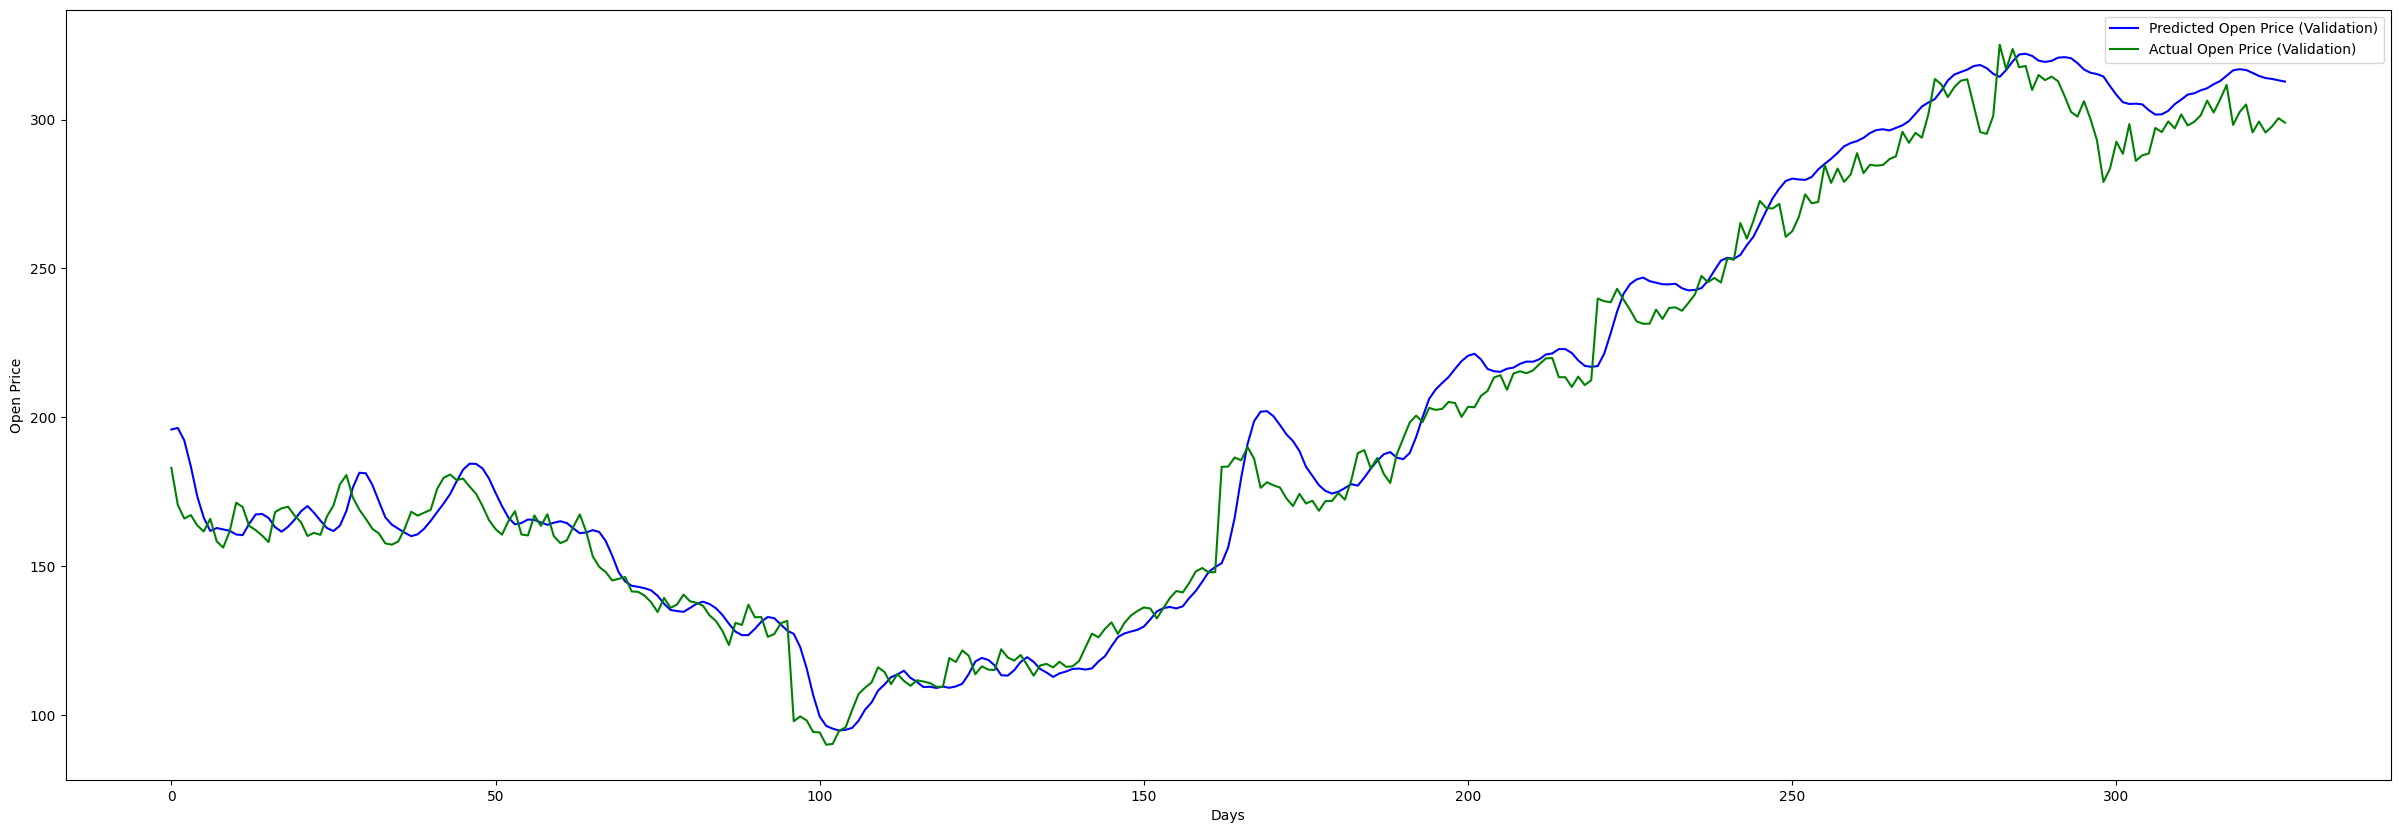

In [ ]:
# Prepare validation data
dataset_validation = np.reshape(validation_data.Open.values, (-1, 1))
scaled_dataset_validation = scaler.fit_transform(dataset_validation)

# Create test sequences
X_test, y_test = [], []
for i in range(time_step, len(scaled_dataset_validation)):
    X_test.append(scaled_dataset_validation[i - time_step:i, 0])
    y_test.append(scaled_dataset_validation[i, 0])

# Convert to numpy arrays and reshape for prediction
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (-1, 1))

# Predict on validation data and inverse transform
y_pred_of_test = scaler.inverse_transform(reg.predict(X_test))

# Plot actual vs predicted values for validation data
plt.figure(figsize=(30, 10))
plt.plot(y_pred_of_test, color='b', label='Predicted Open Price (Validation)')
plt.plot(scaler.inverse_transform(y_test), color='g', label='Actual Open Price (Validation)')

plt.xlabel('Days')
plt.ylabel('Open Price')
plt.legend()
plt.show()


In [ ]:
# Prepare the input data for prediction by scaling and reshaping
X_input=metadata.iloc[-time_step:].Open.values
X_input = scaler.fit_transform(X_input.reshape(-1, 1))
X_input = np.reshape(X_input, (1, 50, 1))
X_input.shape

(1, 50, 1)

In [ ]:
# Predict Open value for next day
simple_RNN_prediction = scaler.inverse_transform(reg.predict(X_input))
simple_RNN_prediction[0, 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


302.23315